In [9]:
import pandas_datareader as pdr
import pandas as pd
import datetime 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [10]:
dataset = pdr.get_data_yahoo('TATN.ME', 
                          start=datetime.datetime(2015, 1, 1), 
                          end=datetime.datetime(2020, 5, 1))

In [11]:
dataset = dataset.reset_index()

In [12]:
dataset['Mean'] = (dataset['Low'] + dataset['High'])/2
dataset

,Date,High,Low,Open,Close,Volume,Adj Close,Mean
0,2015-01-05,238.000000,225.399994,228.500000,238.000000,1164410.0,158.166336,231.699997
1,2015-01-06,243.199997,226.350006,235.949997,228.750000,1736410.0,152.019119,234.775002
2,2015-01-08,250.000000,229.649994,230.000000,245.000000,2178850.0,162.818268,239.824997
3,2015-01-09,247.000000,230.600006,245.899994,234.050003,2122330.0,155.541306,238.800003
4,2015-01-12,237.500000,226.199997,234.250000,228.250000,1776200.0,151.686859,231.849998
...,...,...,...,...,...,...,...,...
1333,2020-04-24,530.900024,514.000000,529.000000,521.900024,5338945.0,521.900024,522.450012
1334,2020-04-27,527.900024,514.000000,520.000000,516.700012,3719260.0,516.700012,520.950012
1335,2020-04-28,538.000000,511.500000,513.000000,529.799988,5690964.0,529.799988,524.750000
1336,2020-04-29,559.000000,532.400024,537.000000,558.599976,6363551.0,558.599976,545.700012


In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
Date         1338 non-null datetime64[ns]
High         1338 non-null float64
Low          1338 non-null float64
Open         1338 non-null float64
Close        1338 non-null float64
Volume       1338 non-null float64
Adj Close    1338 non-null float64
Mean         1338 non-null float64
dtypes: datetime64[ns](1), float64(7)
memory usage: 83.8 KB


In [14]:
steps=-1
dataset_for_prediction= dataset.copy()
dataset_for_prediction['Actual']=dataset_for_prediction['Mean'].shift(steps)
dataset_for_prediction.head(3)

,Date,High,Low,Open,Close,Volume,Adj Close,Mean,Actual
0,2015-01-05,238.000000,225.399994,228.500000,238.00,1164410.0,158.166336,231.699997,234.775002
1,2015-01-06,243.199997,226.350006,235.949997,228.75,1736410.0,152.019119,234.775002,239.824997
2,2015-01-08,250.000000,229.649994,230.000000,245.00,2178850.0,162.818268,239.824997,238.800003


In [15]:
dataset_for_prediction=dataset_for_prediction.dropna()

Text(0.5, 1.0, 'TATN Stock Value')

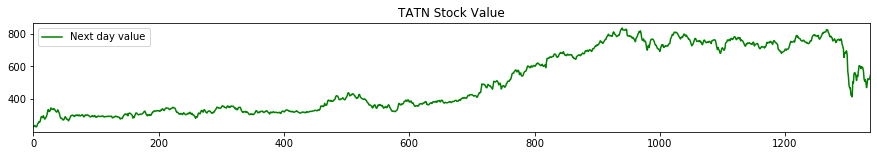

In [16]:
dataset_for_prediction['Mean'].plot(color='green', figsize=(15,2))
plt.legend(['Next day value', 'Mean'])
plt.title("TATN Stock Value")

Text(0.5, 1.0, 'TATN Stock Volume')

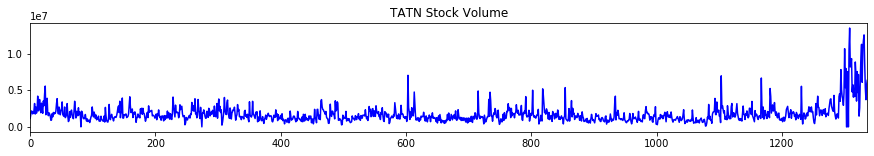

In [17]:
dataset_for_prediction['Volume'].plot(color='blue', figsize=(15,2))
plt.title("TATN Stock Volume")

In [18]:
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction[['Low', 'High','Open', 'Close', 'Volume', 'Adj Close', 'Mean']])
scaled_input =pd.DataFrame(scaled_input)
X= scaled_input

In [19]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])
scaler_output =pd.DataFrame(scaler_output)
y=scaler_output

In [20]:
X.rename(columns={0:'Low', 1:'High', 2:'Open', 3:'Close', 4:'Volume', 5:'Adj Close', 6:'Mean'}, inplace=True)
X.head(2)

,Low,High,Open,Close,Volume,Adj Close,Mean
0,0.000000,0.00082,0.000000,0.016016,0.086044,0.009552,0.000000
1,0.001591,0.00935,0.012145,0.000821,0.128312,0.000490,0.005104


In [21]:
y.rename(columns={0:'Stock Price next day'}, inplace= True)
y.index=dataset_for_prediction.index
y.head(2)

,Stock Price next day
0,0.004856
1,0.013241


In [22]:
train_size=int(len(dataset) *0.7)
test_size = int(len(dataset)) - train_size
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

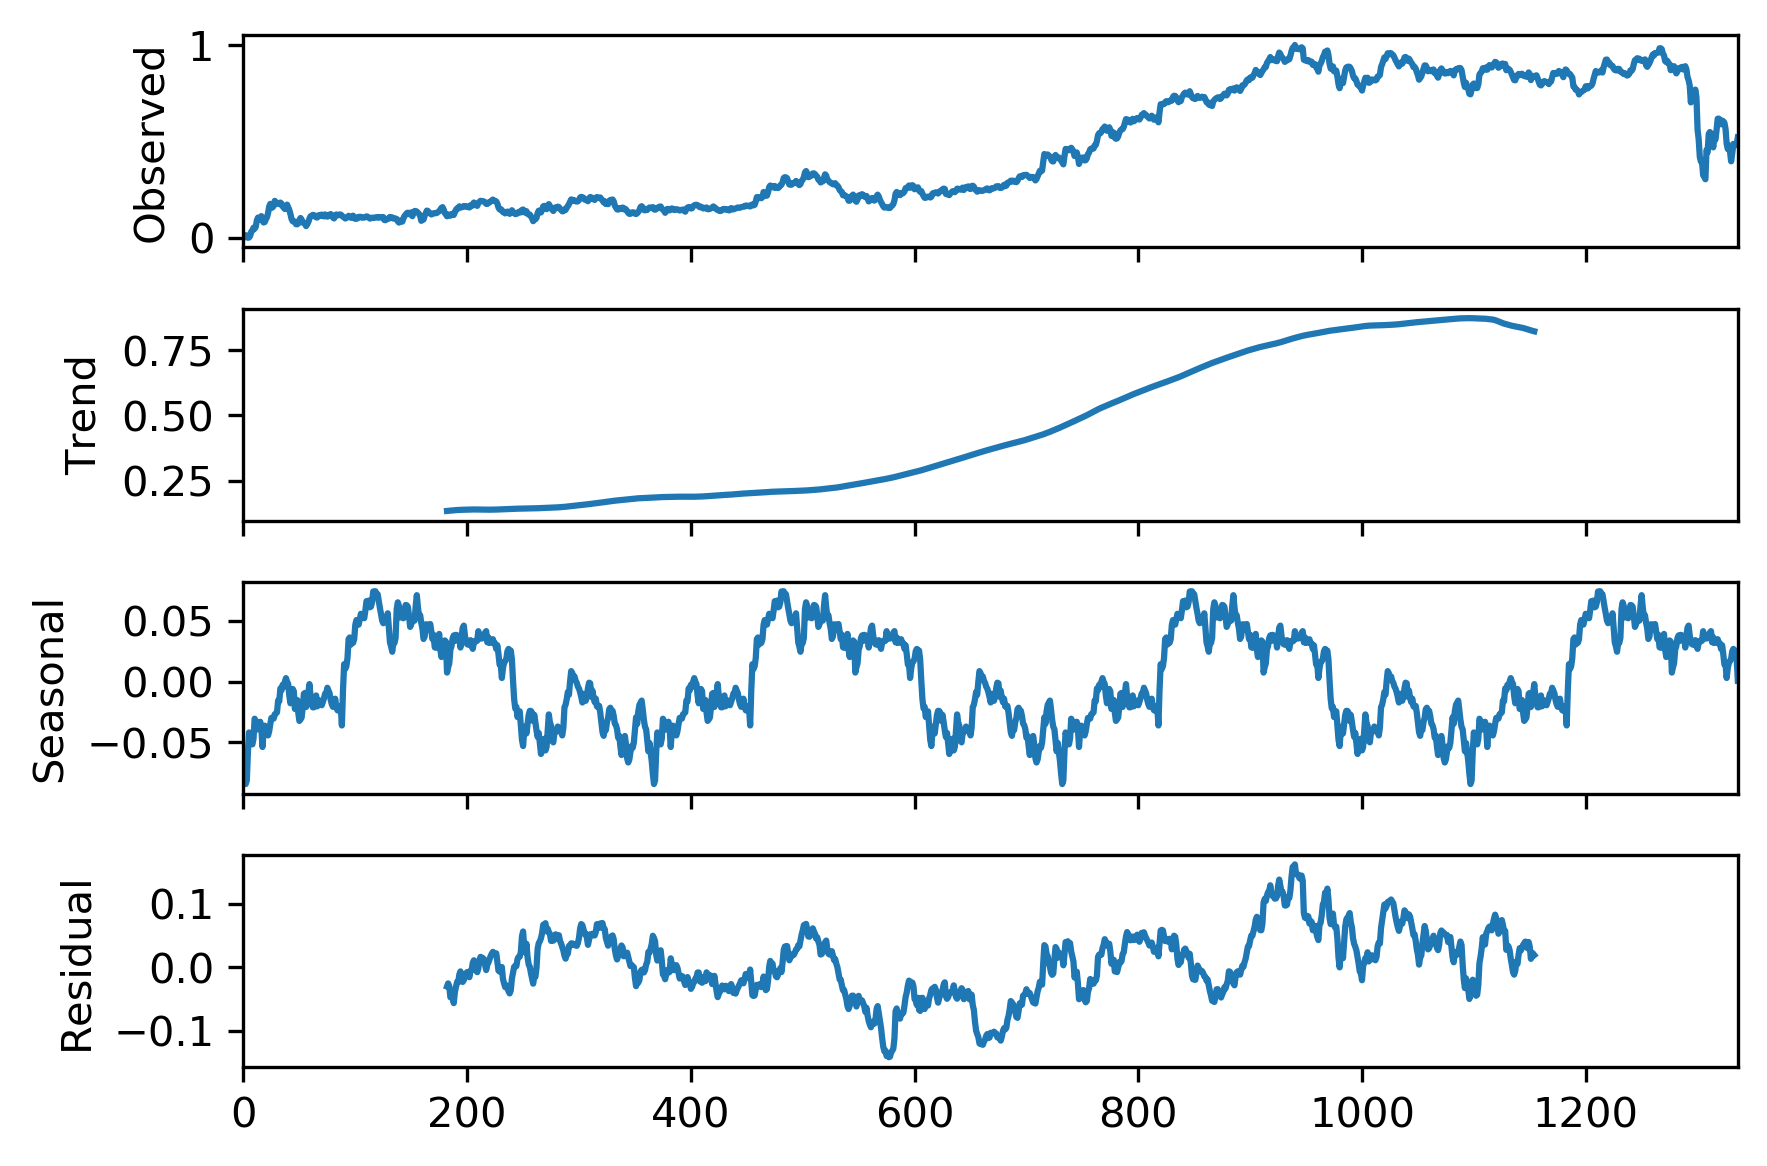

In [23]:
import statsmodels.api as sm
seas_d=sm.tsa.seasonal_decompose(X['Mean'],model='add',freq=365);
fig=seas_d.plot()
fig.set_figheight(4)
fig.dpi=300
plt.show()

In [24]:
from statsmodels.tsa.stattools import adfuller
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [25]:
y_test=y['Stock Price next day'][:train_size].dropna()
test_adf(y_test, "Stock Price")

Strong evidence for  Null Hypothesis
Accept Null Hypothesis - Data is not Stationary
Data is NOT Stationary for Stock Price


In [26]:
test_adf(y_test.diff(), "Stock Price")

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary Stock Price


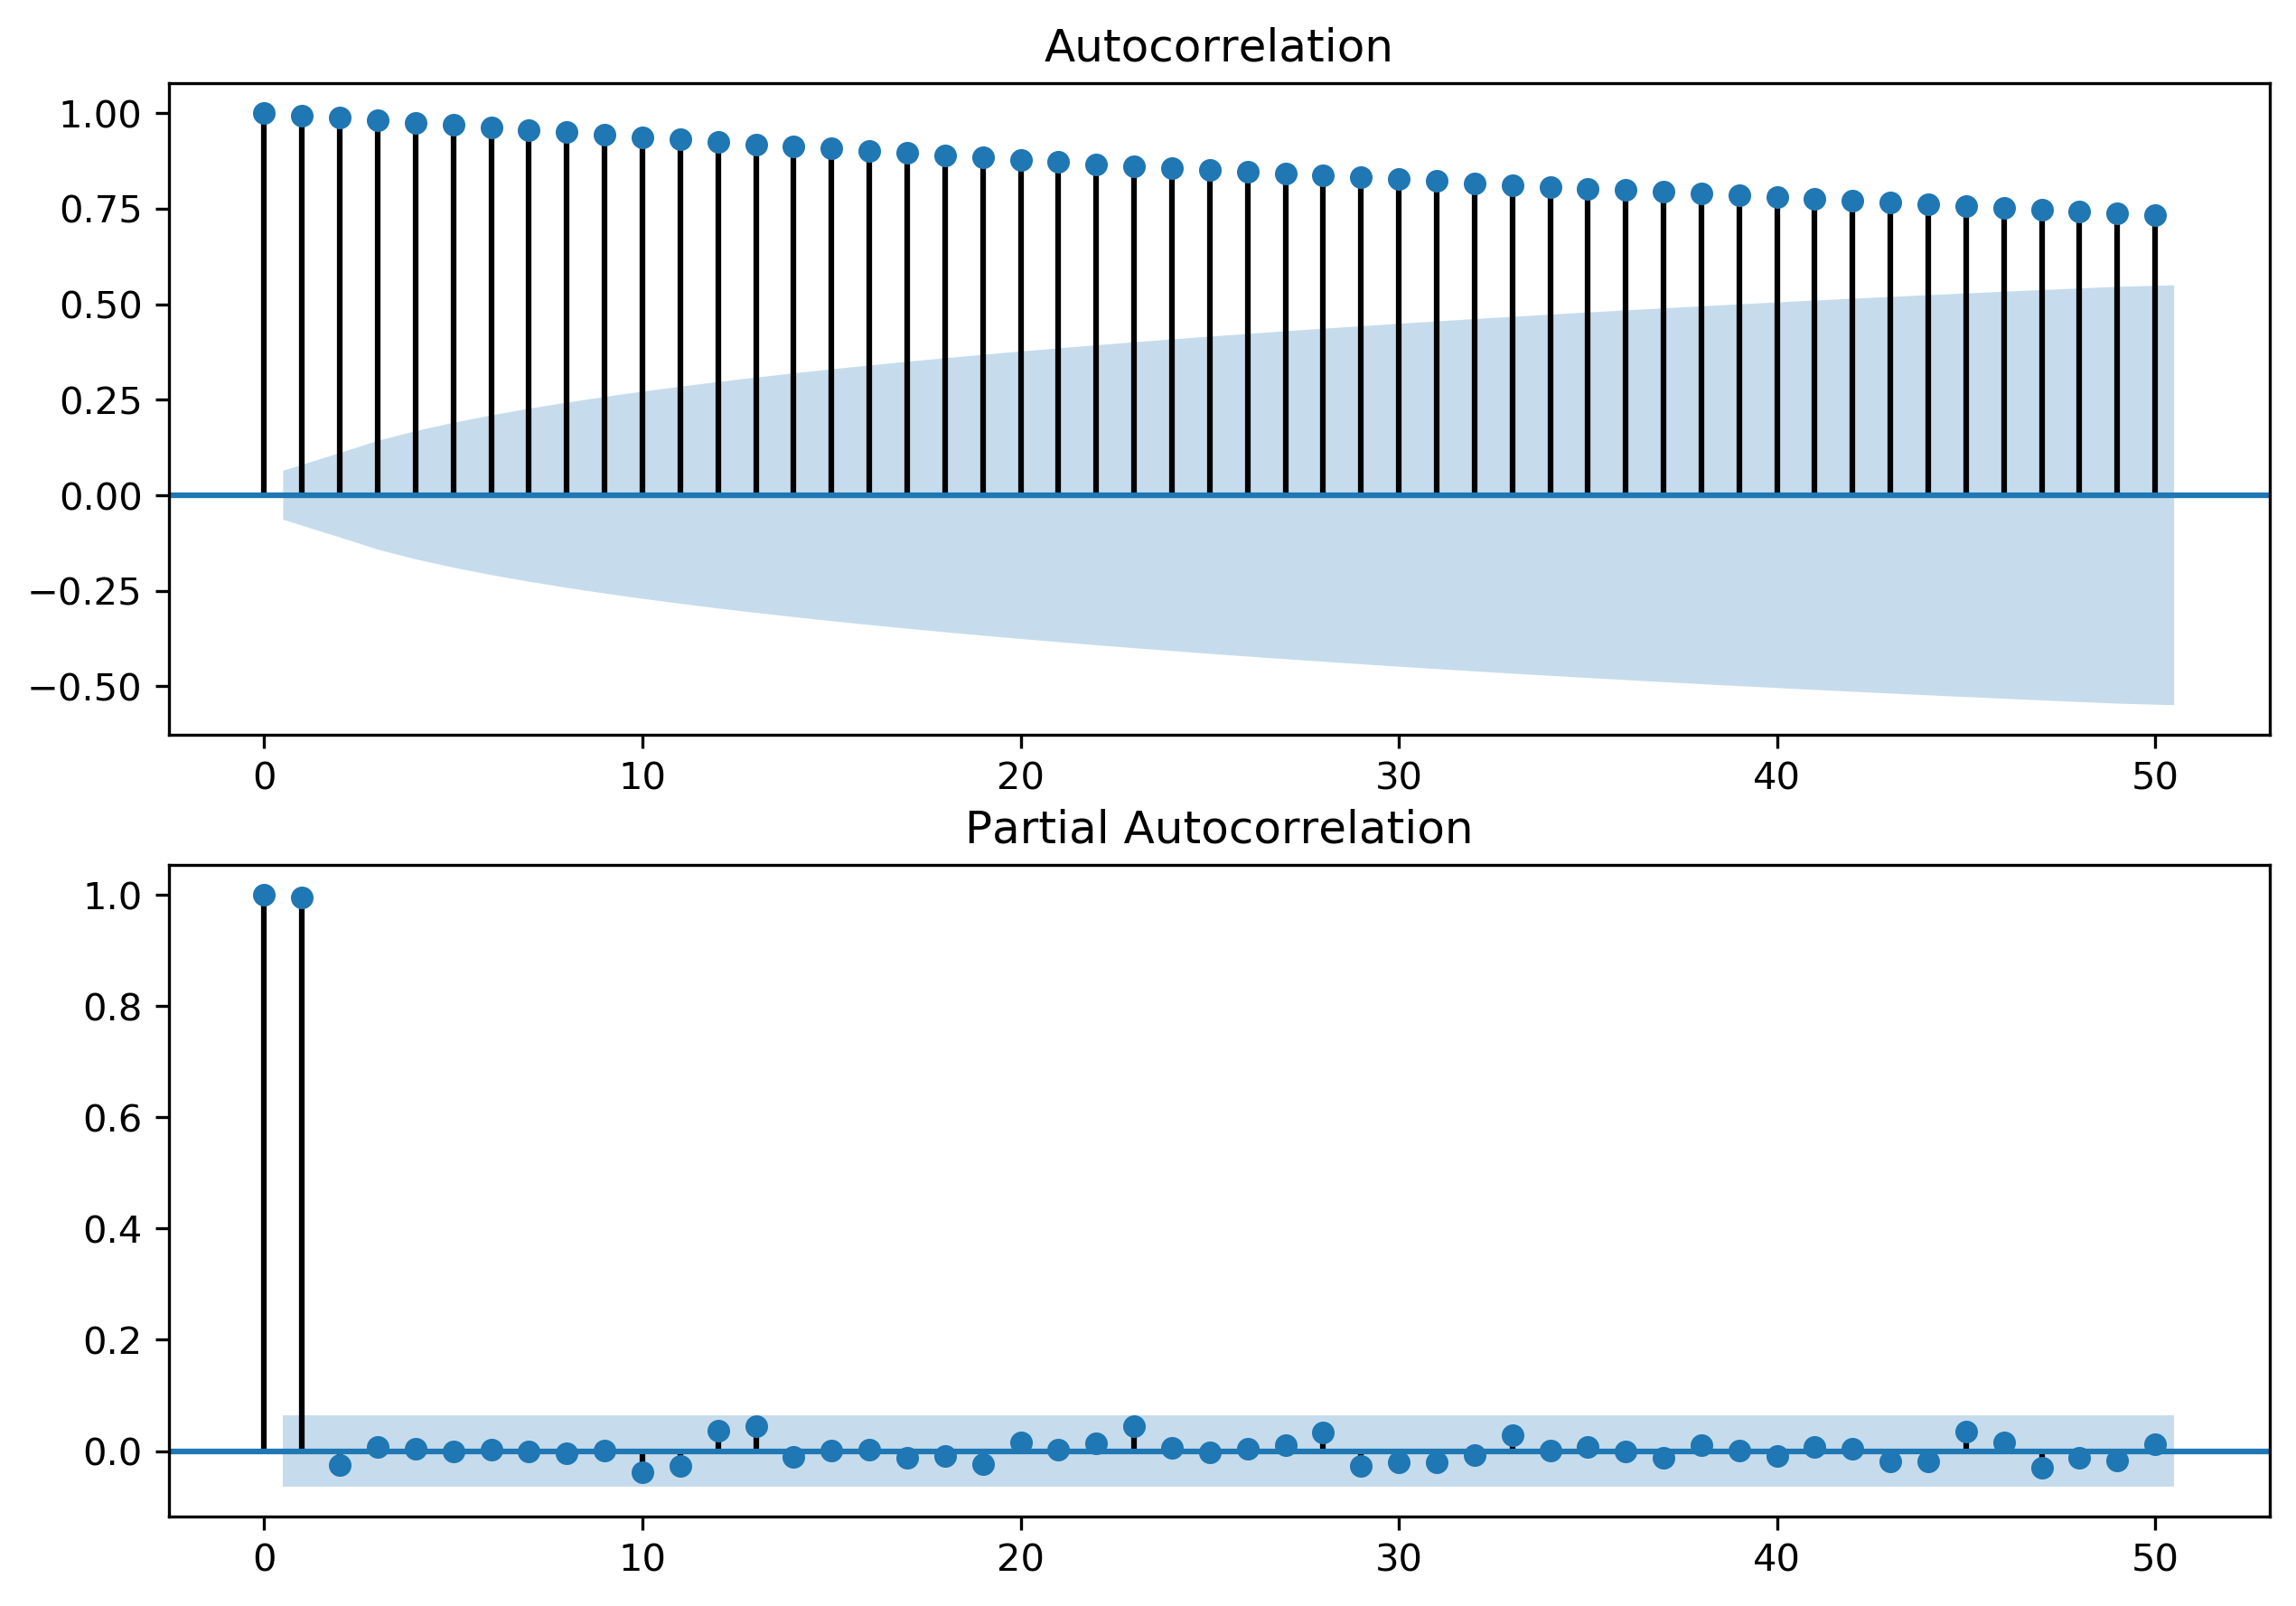

In [27]:
fig,ax= plt.subplots(2,1, figsize=(10,7), dpi=300)
fig=sm.tsa.graphics.plot_acf(y_test, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=50, ax=ax[1])
plt.show()

In [28]:
from pmdarima.arima import auto_arima
step_wise=auto_arima(train_y, 
 exogenous= train_X,
 start_p=1, start_q=1, 
 max_p=7, max_q=7, 
 d=1, max_d=7,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-6395.076, BIC=-6341.830, Fit time=1.693 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-6360.071, BIC=-6316.506, Fit time=0.203 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=-6374.850, BIC=-6326.445, Fit time=0.979 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=-6397.243, BIC=-6348.837, Fit time=1.308 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-6389.963, BIC=-6336.717, Fit time=1.643 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=-6392.527, BIC=-6334.440, Fit time=1.612 seconds
Total fit time: 7.441 seconds


In [29]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  936
Model:               SARIMAX(0, 1, 1)   Log Likelihood                3208.621
Date:                Tue, 12 May 2020   AIC                          -6397.243
Time:                        20:48:57   BIC                          -6348.837
Sample:                             0   HQIC                         -6378.785
                                - 936                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001   8.45e-05      1.515      0.130   -3.76e-05       0.000
x1            -0.1255      0.044     -2.870      0.004      -0.211      -0.040
x2             0.1456      0.048      3.014      0.003       0.051       0.240
x3            -0.0075      0.043     -0.172      0.863      -0.093       0.078
x4             0.6826      0.101      6.749      0.000       0.484       0.881
x5            -0.0041      0.005     -0.759      0.448      -0.015       0.007
x6             0.1596      0.138      1.160      0.246      -0.110       0.429
x7             0.0115      0.029      0.394      0.694      -0.046       0.069
ma.L1         -0.7057      0.078     -9.014      0.000      -0.859      -0.552
sigma2      5.971e-05    1.7e-06     35.186      0.000    5.64e-05     6.3e-05
===================================================================================
Ljung-Box (Q):                       41.47   Jarque-Bera (JB):               713.73
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               1.60   Skew:                             0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.89e+17. Standard errors may be unstable.
"""

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(train_y, 
 exog=train_X,
 order=(0,1,1),
 enforce_invertibility=False, enforce_stationarity=False)

In [31]:
results = model.fit()

c:\users\emilo\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [32]:
predictions= results.predict(start =train_size, end=train_size+test_size+(steps)-1,exog=test_X)

In [33]:
forecast_1= results.forecast(steps=test_size-1, exog=test_X)

In [34]:
act= pd.DataFrame(scaler_output.iloc[train_size:, 0])

In [35]:
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['Stock Price next day']
predictions.rename(columns={0:'Pred'}, inplace=True)

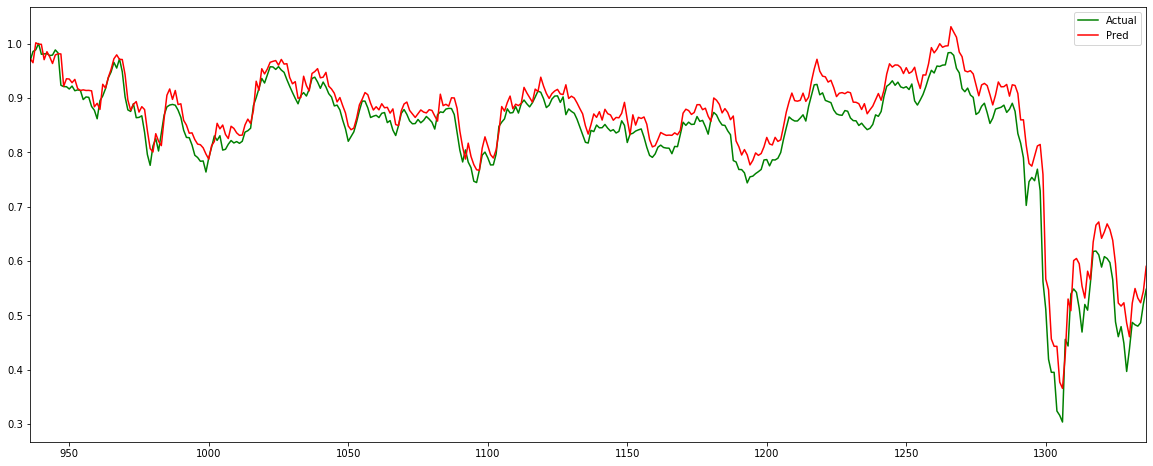

In [36]:
predictions['Actual'].plot(figsize=(20,8), legend=True, color='green')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))
fig.dpi=300

In [37]:
forecast_tatn= pd.DataFrame(forecast_1)
forecast_tatn.reset_index(drop=True, inplace=True)
forecast_tatn.index=test_X.index
forecast_tatn['Actual'] =scaler_output.iloc[train_size:, 0]
forecast_tatn.rename(columns={0:'Forecast'}, inplace=True)

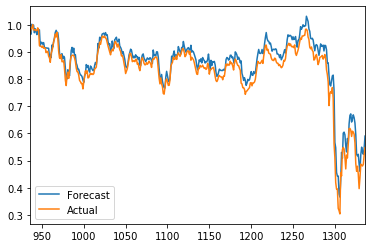

In [38]:
forecast_tatn['Forecast'].plot(legend=True)
forecast_tatn['Actual'].plot(legend=True)

In [39]:
from statsmodels.tools.eval_measures import rmse
error=rmse(predictions['Pred'], predictions['Actual'])
error

0.034856903381830485

In [34]:
trainPredict = sc_out.inverse_transform(predictions[['Pred']])
testPredict = sc_out.inverse_transform(predictions[['Actual']])